In [73]:
import mne
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [74]:
epochs_fname = '/Users/hugofluhr/DATA/ds003505/derivatives/eeglab-v14.1.1/sub-01/eeg/sub-01_task-faces_desc-preproc_eeg.set'

In [75]:
beh_fname = '/Users/hugofluhr/DATA/ds003505/sub-01/eeg/sub-01_task-faces_events.tsv'
beh = pd.read_csv(beh_fname, sep="\t")
beh = beh[beh.bad_epoch == 0]

In [76]:
epochs = mne.read_epochs_eeglab(
            epochs_fname,
            events=None,
            event_id=None,
            eog=(),
            verbose=False,
            uint16_codec=None,
        )

epochs.events[:, 2] = list(beh.trial_type_id)

epochs.event_id = {"Scrambled": 0, "Faces": 1}

/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_59391/4252855035.py:1: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(


In [77]:
epochs

Number of events,588
Events,Faces: 294Scrambled: 294
Time range,-1.500 – 0.996 s
Baseline,off


In [79]:
montage_fname = '/Users/hugofluhr/DATA/ds003505/derivatives/mne/sub-01/sub-01_task-faces_montage.fif'
montage = mne.channels.read_dig_fif(montage_fname)

mapping = {f"EEG{str(i + 1).zfill(3)}": ch["ch_name"] for i, ch in enumerate(epochs.info["chs"])}
montage.rename_channels(mapping)

epochs.set_montage(montage)
epochs.apply_baseline((-0.2, 0))
epochs.set_eeg_reference(ref_channels="average", projection=True)

epochs.crop(tmin=-0.2, tmax=0.5)
#evoked = epochs[condition].average().pick("eeg")


Applying baseline correction (mode: mean)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Number of events,588
Events,Faces: 294Scrambled: 294
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


## PLI Connectivity

In [80]:
fmin, fmax = 4., 9.
sfreq = epochs.info['sfreq']
tmin = 0.0 # exclude the baseline period

In [197]:
con_faces = spectral_connectivity_epochs(
    epochs['Faces'], method='plv', mode='multitaper', fmin=10, fmax=50,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8, verbose='CRITICAL')

In [198]:
con_scram = spectral_connectivity_epochs(
    epochs['Scrambled'], method='plv', mode='multitaper', fmin=10, fmax=50,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8, verbose='CRITICAL')

In [199]:
A_faces = np.squeeze(con_faces.get_data('dense'))
A_faces += A_faces.T

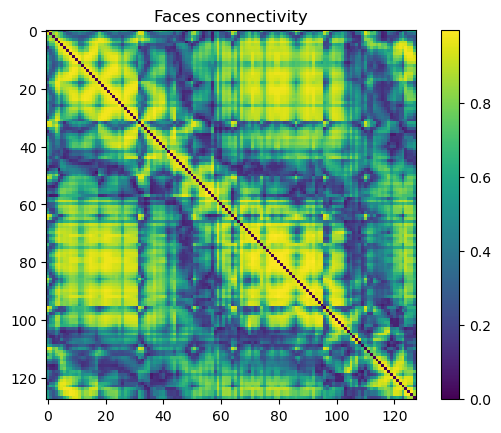

In [200]:
plt.imshow(A_faces, interpolation='none')
plt.colorbar()
plt.title('Faces connectivity');

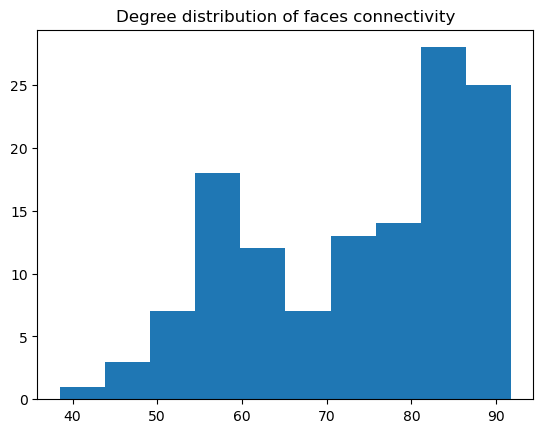

In [201]:
plt.hist(A_faces.sum(0))
plt.title('Degree distribution of faces connectivity')
plt.show()

In [202]:
A_scram = np.squeeze(con_scram.get_data('dense'))
A_scram += A_scram.T

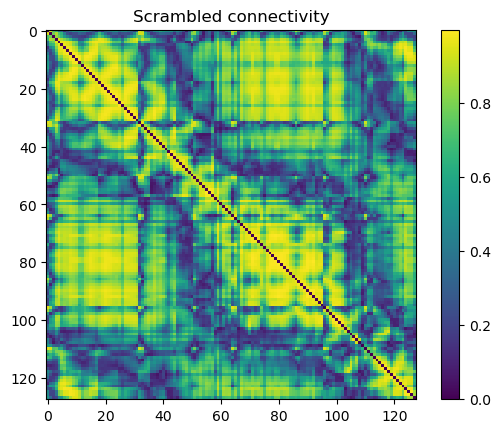

In [203]:
plt.imshow(A_scram, interpolation='none')
plt.colorbar()
plt.title('Scrambled connectivity');

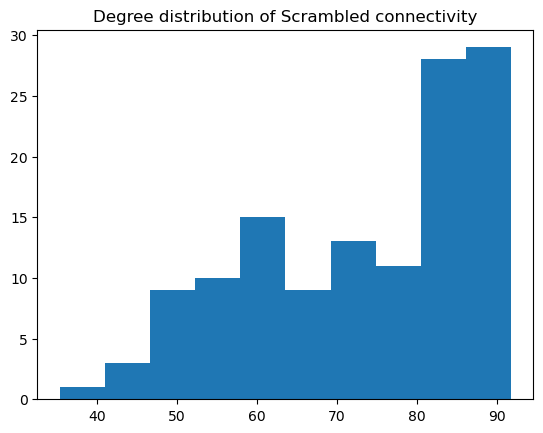

In [204]:
plt.hist(A_scram.sum(0))
plt.title('Degree distribution of Scrambled connectivity')
plt.show()

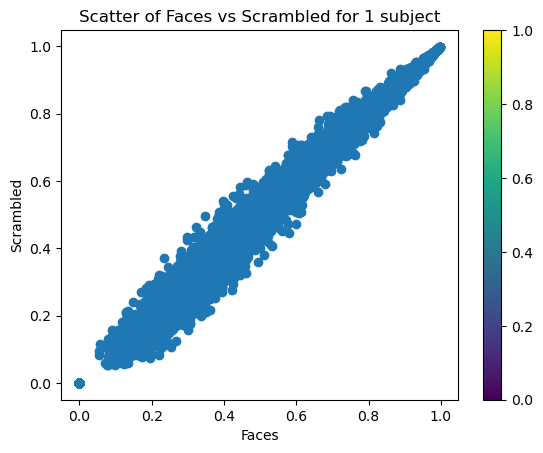

In [205]:
plt.scatter(np.triu(A_faces), np.triu(A_scram))
plt.colorbar()
plt.title('Scatter of Faces vs Scrambled for 1 subject')
plt.xlabel('Faces')
plt.ylabel('Scrambled')
plt.show()

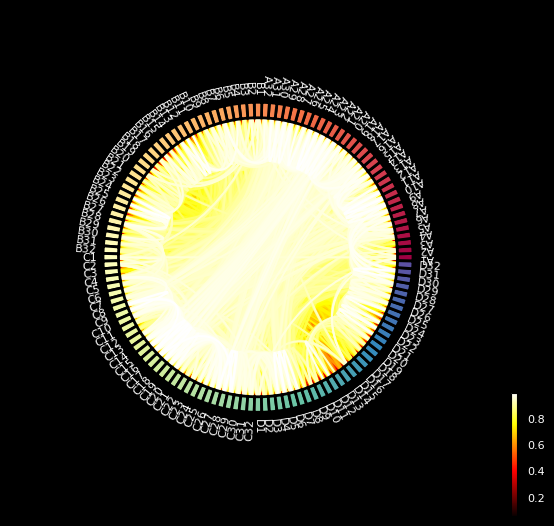

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [206]:
# Fancy useless plot
plot_connectivity_circle(
    con_faces.get_data(output='dense')[:, :, 0],
    epochs.ch_names)

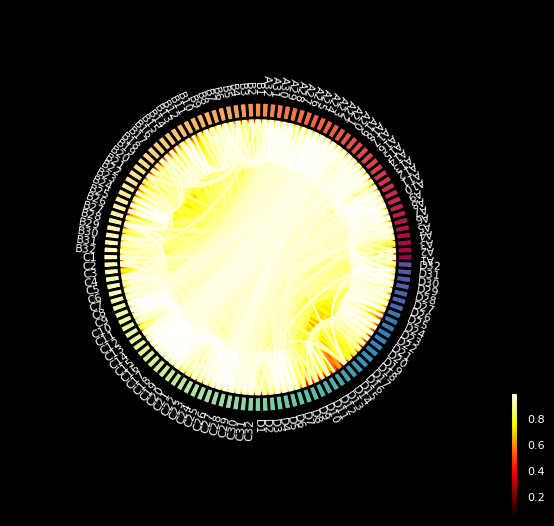

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [207]:
# Fancy useless plot
plot_connectivity_circle(
    con_scram.get_data(output='dense')[:, :, 0],
    epochs.ch_names)

## Enveloppe correlation connectivity

In [208]:
from mne_connectivity import envelope_correlation

In [209]:
env_con = envelope_correlation(epochs['Faces'])

/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_59391/4000093218.py:1: RuntimeWarning: There were no Annotations stored in <EpochsEEGLAB |  294 events (all good), -0.2 – 0.5 s, baseline -0.2 – 0 s, ~50.7 MB, data loaded,
 'Faces': 294>, so metadata was not modified.
  env_con = envelope_correlation(epochs['Faces'])


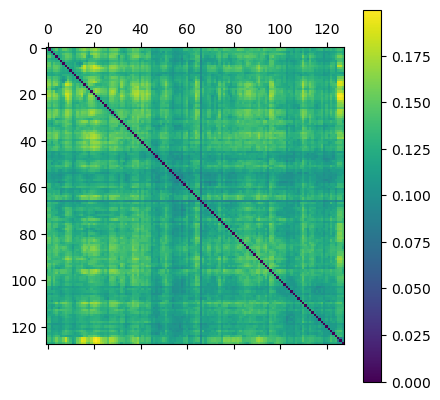

In [210]:
plt.matshow(env_con.get_data('dense').mean(0))
plt.colorbar()

In [211]:
env_con_sram = envelope_correlation(epochs['Scrambled'])

/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_59391/1992332363.py:1: RuntimeWarning: There were no Annotations stored in <EpochsEEGLAB |  294 events (all good), -0.2 – 0.5 s, baseline -0.2 – 0 s, ~50.7 MB, data loaded,
 'Scrambled': 294>, so metadata was not modified.
  env_con_sram = envelope_correlation(epochs['Scrambled'])


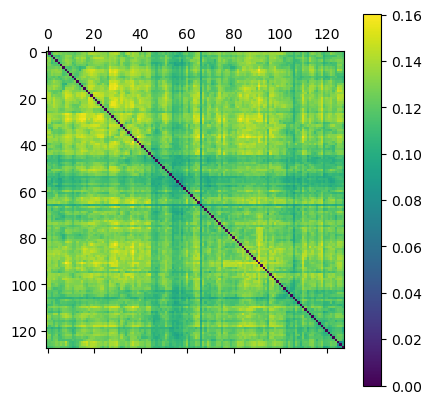

In [212]:
plt.matshow(env_con_sram.get_data('dense').mean(0))
plt.colorbar()

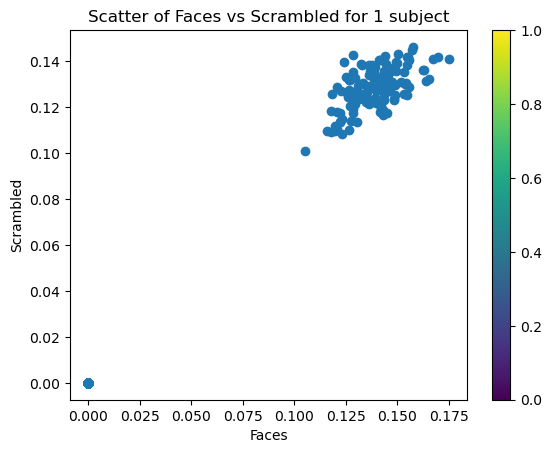

In [213]:
plt.scatter(np.triu(env_con.get_data('dense').mean(0)), np.triu(env_con_sram.get_data('dense').mean(0)))
plt.colorbar()
plt.title('Scatter of Faces vs Scrambled for 1 subject')
plt.xlabel('Faces')
plt.ylabel('Scrambled')
plt.show()

In [214]:
env_con.get_data('dense').mean(0).shape

(128, 128, 1)

## Compare connectivity from different epochs

In [215]:
epochs['Faces']


Number of events,294
Events,Faces: 294
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [216]:
con_faces_1 = spectral_connectivity_epochs(
    epochs['Faces'][:10], method='plv', mode='multitaper', fmin=10, fmax=50,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8, verbose='CRITICAL')

In [217]:
con_faces_2 = spectral_connectivity_epochs(
    epochs['Faces'][-10:], method='plv', mode='multitaper', fmin=10, fmax=50,
    faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=8, verbose='CRITICAL')

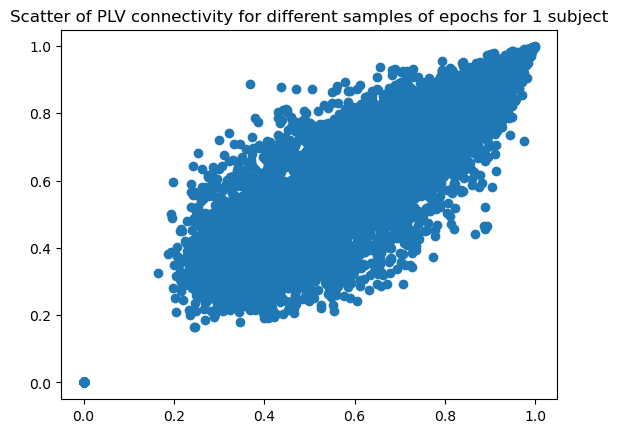

In [218]:
plt.scatter(con_faces_1.get_data('dense'),con_faces_2.get_data('dense'))
plt.title('Scatter of PLV connectivity for different samples of epochs for 1 subject')
plt.show()

## Evoked response for 1 subject

In [239]:
evoked = epochs.average(by_event_type=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


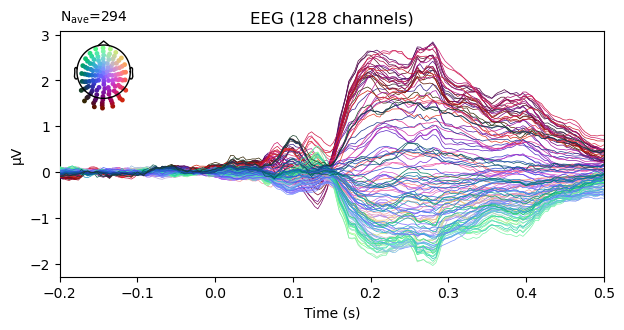

In [231]:
evoked[0].plot();

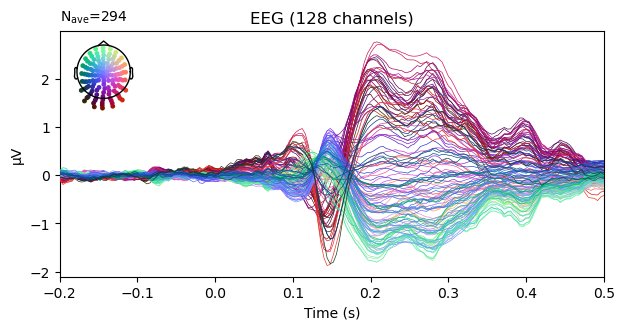

In [232]:
evoked[1].plot();

In [235]:
evoked_diff = mne.combine_evoked([evoked[1], evoked[0]], weights=[1, -1])

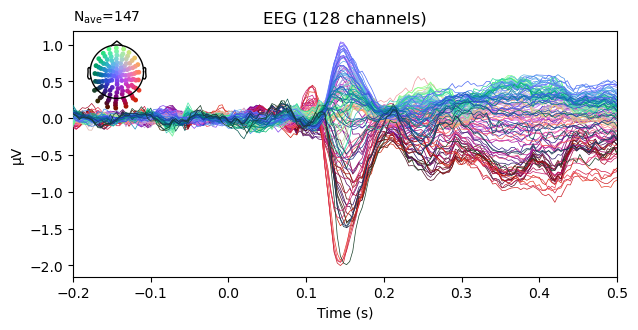

In [237]:
evoked_diff.plot();